## Boosted regression trees
Trying boosted regression trees in the gbm package, including lag and lead for all variables except depth.

[This is me](https://www.linkedin.com/in/%C3%B8ystein-s%C3%B8rensen-4a877831/)

## Data load

In [1]:
trainingData <- read.csv("../training_data.csv")
testData <- read.csv("../validation_data_nofacies.csv")

# Convert the class labels to factora
trainingData$Facies <- as.factor(trainingData$Facies)

# Add a Facies column to test data
testData <- cbind(Facies = as.factor(-1), testData)

## Some feature engineering
Adding lead and lag for every row. In the top and bottom, I replace NA with the current value.

In [2]:
# Reorganizing the columns, putting the columns to have lag/lead at the end
order <- c("Facies", "Well.Name", "Depth", "RELPOS", "Formation", "GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M")

trainingData <- trainingData[, order]
testData <- testData[, order]

Printing out the data frame to confirm that the transformation was correct.

In [3]:
head(trainingData)
head(testData)

Facies,Well.Name,Depth,RELPOS,Formation,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M
3,SHRIMPLIN,2793.0,1.000,A1 SH,77.45,0.664,9.9,11.915,4.6,1
3,SHRIMPLIN,2793.5,0.979,A1 SH,78.26,0.661,14.2,12.565,4.1,1
3,SHRIMPLIN,2794.0,0.957,A1 SH,79.05,0.658,14.8,13.050,3.6,1
3,SHRIMPLIN,2794.5,0.936,A1 SH,86.10,0.655,13.9,13.115,3.5,1
3,SHRIMPLIN,2795.0,0.915,A1 SH,74.58,0.647,13.5,13.300,3.4,1
3,SHRIMPLIN,2795.5,0.894,A1 SH,73.97,0.636,14.0,13.385,3.6,1


Facies,Well.Name,Depth,RELPOS,Formation,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M
-1,STUART,2808.0,1.000,A1 SH,66.276,0.630,3.3,10.65,3.591,1
-1,STUART,2808.5,0.978,A1 SH,77.252,0.585,6.5,11.95,3.341,1
-1,STUART,2809.0,0.956,A1 SH,82.899,0.566,9.4,13.60,3.064,1
-1,STUART,2809.5,0.933,A1 SH,80.671,0.593,9.5,13.25,2.977,1
-1,STUART,2810.0,0.911,A1 SH,75.971,0.638,8.7,12.35,3.020,1
-1,STUART,2810.5,0.889,A1 SH,73.955,0.667,6.9,12.25,3.086,1


In [4]:
library(dplyr)

featureEng <- function(x) {
    x <- x %>%    
        group_by(Well.Name) %>%
        mutate(
            prev.Formation = lag(Formation), next.Formation = lead(Formation),
            prev.GR = lag(GR), next.GR = lead(GR),
            prev.ILD_log10 = lag(ILD_log10), next.ILD_log10 = lead(ILD_log10),
            prev.DeltaPHI = lag(DeltaPHI), next.DeltaPHI = lead(DeltaPHI),
            prev.PHIND = lag(PHIND), next.PHIND = lead(PHIND),
            prev.PE = lag(PE), next.PE = lead(PE),
            prev.NM_M = lag(NM_M), next.NM_M = lead(NM_M)
        )

    vec <- 5:11 # The columns which have lag/lead
    for(i in seq_along(vec)) { 
        cols <- vec[i] + 6 + i 
        rows <- is.na(x[, cols])
        x[rows, cols] <- x[rows, vec[i]]
        cols <- vec[i] + 7 + i 
        rows <- is.na(x[, cols])
        x[rows, cols] <- x[rows, vec[i]]
        }
    return(x)
}



Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



In [5]:
trainingData <- featureEng(trainingData)
testData <- featureEng(testData)

In [6]:
head(trainingData)

Facies,Well.Name,Depth,RELPOS,Formation,GR,ILD_log10,DeltaPHI,PHIND,PE,...,prev.ILD_log10,next.ILD_log10,prev.DeltaPHI,next.DeltaPHI,prev.PHIND,next.PHIND,prev.PE,next.PE,prev.NM_M,next.NM_M
3,SHRIMPLIN,2793.0,1.000,A1 SH,77.45,0.664,9.9,11.915,4.6,...,0.664,0.661,9.9,14.2,11.915,12.565,4.6,4.1,1,1
3,SHRIMPLIN,2793.5,0.979,A1 SH,78.26,0.661,14.2,12.565,4.1,...,0.664,0.658,9.9,14.8,11.915,13.050,4.6,3.6,1,1
3,SHRIMPLIN,2794.0,0.957,A1 SH,79.05,0.658,14.8,13.050,3.6,...,0.661,0.655,14.2,13.9,12.565,13.115,4.1,3.5,1,1
3,SHRIMPLIN,2794.5,0.936,A1 SH,86.10,0.655,13.9,13.115,3.5,...,0.658,0.647,14.8,13.5,13.050,13.300,3.6,3.4,1,1
3,SHRIMPLIN,2795.0,0.915,A1 SH,74.58,0.647,13.5,13.300,3.4,...,0.655,0.636,13.9,14.0,13.115,13.385,3.5,3.6,1,1
3,SHRIMPLIN,2795.5,0.894,A1 SH,73.97,0.636,14.0,13.385,3.6,...,0.647,0.630,13.5,15.6,13.300,13.930,3.4,3.7,1,1


## Multinomial boosted tree model

In [7]:
form <- as.formula(paste("Facies ~ ", paste(colnames(trainingData[, -(1:2)]), collapse = "+"), sep = " "))
form

Facies ~ Depth + RELPOS + Formation + GR + ILD_log10 + DeltaPHI + 
    PHIND + PE + NM_M + prev.Formation + next.Formation + prev.GR + 
    next.GR + prev.ILD_log10 + next.ILD_log10 + prev.DeltaPHI + 
    next.DeltaPHI + prev.PHIND + next.PHIND + prev.PE + next.PE + 
    prev.NM_M + next.NM_M

In [8]:
library(gbm) # Using the gbm package
library(parallel)
# Training the model using 10-fold cross validation
fit <- gbm(form,
           distribution = "multinomial",
           n.trees = 10000,
           shrinkage = 0.003,
           interaction.depth = 8,
           cv.folds = 10,
           data = trainingData, 
           keep.data = FALSE,
           n.cores = 4
          )

Loading required package: survival
Loading required package: lattice
Loading required package: splines
Loading required package: parallel
Loaded gbm 2.1.1


## Inspect the performance

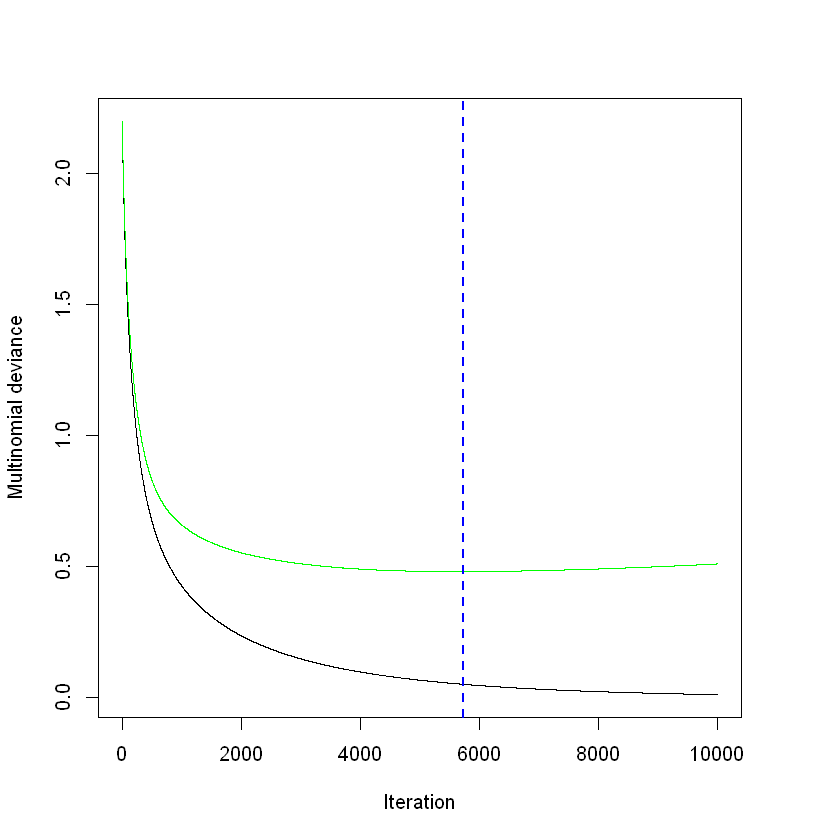

In [9]:
optNumTrees <- gbm.perf(fit, method = "cv")

## Prediction

In [10]:
# Compute the link function
estimatedLink <- predict(fit, newdata = testData, type = "link", n.trees = optNumTrees)[,,1]
# Use the classification with highest probability
testData$Facies <- apply(estimatedLink, 1, which.max)

In [11]:
head(testData)

Facies,Well.Name,Depth,RELPOS,Formation,GR,ILD_log10,DeltaPHI,PHIND,PE,...,prev.ILD_log10,next.ILD_log10,prev.DeltaPHI,next.DeltaPHI,prev.PHIND,next.PHIND,prev.PE,next.PE,prev.NM_M,next.NM_M
3,STUART,2808.0,1.000,A1 SH,66.276,0.630,3.3,10.65,3.591,...,0.630,0.585,3.3,6.5,10.65,11.95,3.591,3.341,1,1
3,STUART,2808.5,0.978,A1 SH,77.252,0.585,6.5,11.95,3.341,...,0.630,0.566,3.3,9.4,10.65,13.60,3.591,3.064,1,1
3,STUART,2809.0,0.956,A1 SH,82.899,0.566,9.4,13.60,3.064,...,0.585,0.593,6.5,9.5,11.95,13.25,3.341,2.977,1,1
3,STUART,2809.5,0.933,A1 SH,80.671,0.593,9.5,13.25,2.977,...,0.566,0.638,9.4,8.7,13.60,12.35,3.064,3.020,1,1
3,STUART,2810.0,0.911,A1 SH,75.971,0.638,8.7,12.35,3.020,...,0.593,0.667,9.5,6.9,13.25,12.25,2.977,3.086,1,1
3,STUART,2810.5,0.889,A1 SH,73.955,0.667,6.9,12.25,3.086,...,0.638,0.674,8.7,6.5,12.35,12.45,3.020,3.092,1,1


In [18]:
# Write to csv
write.csv(testData, file = "./prediction.csv", row.names = FALSE)